In [36]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [37]:
#Importing the data
df = pd.read_csv(r"C:\Users\Pranav\Downloads\13. Capstone Case Study - Demand Estimation\Electricity Consumption.csv")

In [38]:
df

,DATE,Electricty_Consumption_in_TW
0,1/1/1973,35.9728
1,2/1/1973,36.1334
2,3/1/1973,35.0625
3,4/1/1973,33.8416
4,5/1/1973,33.5107
...,...,...
556,5/1/2019,97.5860
557,6/1/2019,110.8580
558,7/1/2019,122.1014
559,8/1/2019,121.7765


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   DATE                          561 non-null    object 
 1   Electricty_Consumption_in_TW  561 non-null    float64
dtypes: float64(1), object(1)
memory usage: 8.9+ KB


In [40]:
#Checking for null values
df.isna().sum()

DATE                            0
Electricty_Consumption_in_TW    0
dtype: int64

In [41]:
#Converting  the datatype of DATE column into datetime
df['DATE'] = pd.to_datetime(df['DATE'])

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   DATE                          561 non-null    datetime64[ns]
 1   Electricty_Consumption_in_TW  561 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.9 KB


In [43]:
#Setting the Date column into index
df.set_index('DATE',inplace=True)

In [44]:
df

,Electricty_Consumption_in_TW
DATE,
1973-01-01,35.9728
1973-02-01,36.1334
1973-03-01,35.0625
1973-04-01,33.8416
1973-05-01,33.5107
...,...
2019-05-01,97.5860
2019-06-01,110.8580
2019-07-01,122.1014


<AxesSubplot:xlabel='DATE'>

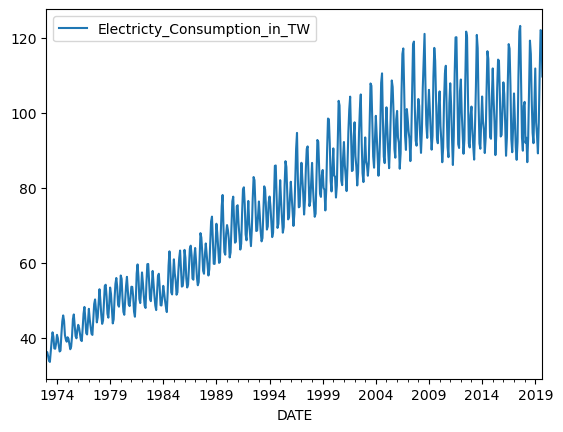

In [45]:
#Ploting a diagram for df
df.plot()

The diagram shows the seasonality of the data

In [46]:
new_df = df

In [47]:
#Importing Dickey-Fuller test for checking whether the data is stationary or not
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series)
    print('ADF statistics: {}'.format(result[0]))
    print('p value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print('data is stationary')
    else:
        print('data is not stationary')

In [48]:
adf_test(new_df['Electricty_Consumption_in_TW'])

ADF statistics: -1.7405933729832284
p value: 0.41032816044687603
data is not stationary


The data is non-stationary. Therefore, verify its stationarity by examining the first difference

In [49]:
#creating the column first difference
new_df['Electricty_Consumption_First_diff'] = new_df['Electricty_Consumption_in_TW'] - new_df['Electricty_Consumption_in_TW'].shift(1)

In [50]:
new_df['Electricty_Consumption_First_diff']

DATE
1973-01-01        NaN
1973-02-01     0.1606
1973-03-01    -1.0709
1973-04-01    -1.2209
1973-05-01    -0.3309
               ...   
2019-05-01     8.3987
2019-06-01    13.2720
2019-07-01    11.2434
2019-08-01    -0.3249
2019-09-01   -12.0575
Name: Electricty_Consumption_First_diff, Length: 561, dtype: float64

In [51]:
#Checking whether the first diff is stationary or not
adf_test(new_df['Electricty_Consumption_First_diff'].dropna())

ADF statistics: -7.941665363981172
p value: 3.3013438021516752e-12
data is stationary


In [52]:
#The data exhibits seasonality, necessitating the adoption of a 12th difference for SARIMA modeling
new_df['Electricty_Consumption_12th_diff'] = new_df['Electricty_Consumption_in_TW'] - new_df['Electricty_Consumption_in_TW'].shift(12)

In [53]:
##Checking whether the 12th diff is stationary or not
adf_test(new_df['Electricty_Consumption_12th_diff'].dropna())

ADF statistics: -6.283726159436479
p value: 3.7419901755219934e-08
data is stationary


In [54]:
#Importing the acf and pacf library
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

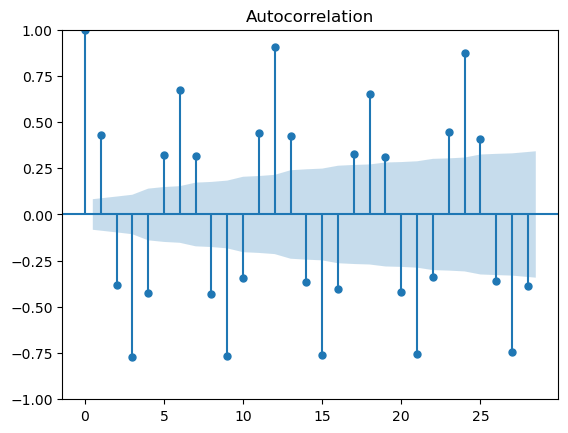

In [55]:
#Ploting the acf diagram for first diff for finding the Moving Average (q)
acf = plot_acf(new_df['Electricty_Consumption_First_diff'].dropna())

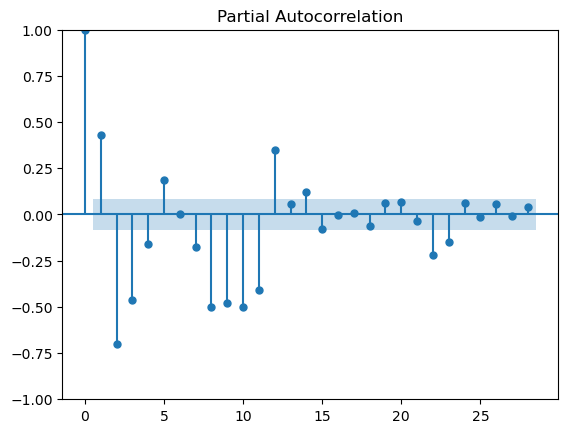

In [56]:
##Ploting the pacf diagram for first diff for finding the p value
pacf = plot_pacf(new_df['Electricty_Consumption_First_diff'].dropna())

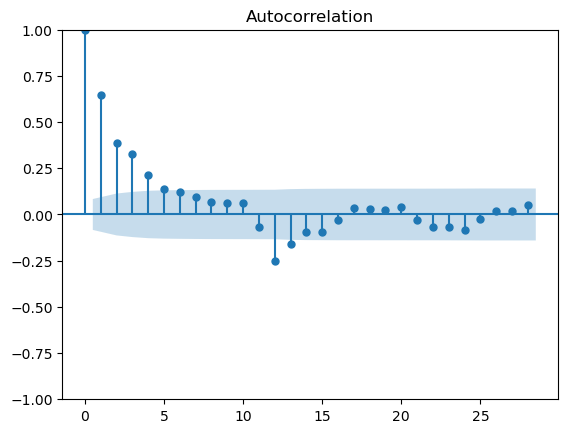

In [57]:
#Ploting the acf diagram for 12th diff for finding the Moving Average (q)
acf_test = plot_acf(new_df['Electricty_Consumption_12th_diff'].dropna())

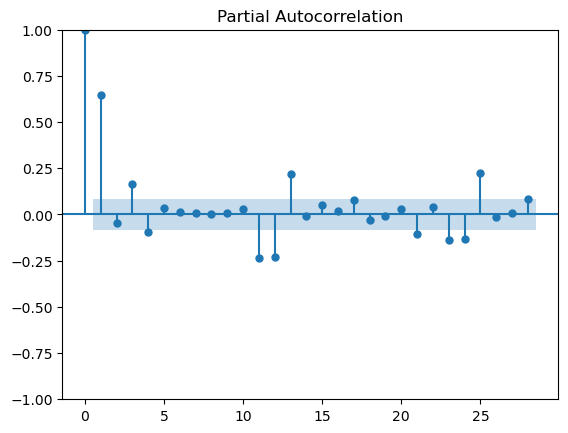

In [58]:
##Ploting the pacf diagram for 12th diff for finding the p value
pacf_test = plot_pacf(new_df['Electricty_Consumption_12th_diff'].dropna())

In [59]:
#Splitting the data into train, test
train_size = int(len(new_df) * 0.8)
train, test = new_df.iloc[:train_size], new_df.iloc[train_size:]

In [60]:
train

,Electricty_Consumption_in_TW,Electricty_Consumption_First_diff,Electricty_Consumption_12th_diff
DATE,,,
1973-01-01,35.9728,NaN,NaN
1973-02-01,36.1334,0.1606,NaN
1973-03-01,35.0625,-1.0709,NaN
1973-04-01,33.8416,-1.2209,NaN
1973-05-01,33.5107,-0.3309,NaN
...,...,...,...
2009-12-01,101.8014,9.9037,0.9417
2010-01-01,105.7413,3.9399,-0.4047
2010-02-01,96.4428,-9.2985,-4.0009


In [61]:
test

,Electricty_Consumption_in_TW,Electricty_Consumption_First_diff,Electricty_Consumption_12th_diff
DATE,,,
2010-05-01,90.6389,3.8147,-3.2236
2010-06-01,103.0377,12.3988,-6.5474
2010-07-01,110.6045,7.5668,-6.7460
2010-08-01,112.5792,1.9747,-1.3031
2010-09-01,100.4701,-12.1091,-2.8790
...,...,...,...
2019-05-01,97.5860,8.3987,4.3499
2019-06-01,110.8580,13.2720,3.7571
2019-07-01,122.1014,11.2434,2.8140


In [62]:
#Setting the start and end dates for the test data to predict the testing dataset
pred_start_date = test.index[0]
pred_end_date = test.index[-1]

In [63]:
pred_end_date

Timestamp('2019-09-01 00:00:00')

# ARIMA

In [64]:
#Model building
from statsmodels.tsa.arima.model import ARIMA

In [65]:
model_Arima = ARIMA(train['Electricty_Consumption_in_TW'],order=[14,1,28])

In [66]:
model_Arima = model_Arima.fit()

In [67]:
pred = model_Arima.predict(start = pred_start_date,end = pred_end_date)

In [68]:
#Finding the RMSE
residual = test['Electricty_Consumption_in_TW'] - pred

sqrd_err = residual **2


mse = np.mean(sqrd_err)

rmse = np.sqrt(mse)

In [69]:
test

,Electricty_Consumption_in_TW,Electricty_Consumption_First_diff,Electricty_Consumption_12th_diff
DATE,,,
2010-05-01,90.6389,3.8147,-3.2236
2010-06-01,103.0377,12.3988,-6.5474
2010-07-01,110.6045,7.5668,-6.7460
2010-08-01,112.5792,1.9747,-1.3031
2010-09-01,100.4701,-12.1091,-2.8790
...,...,...,...
2019-05-01,97.5860,8.3987,4.3499
2019-06-01,110.8580,13.2720,3.7571
2019-07-01,122.1014,11.2434,2.8140


In [70]:
#Finding RMSPE, MAPE
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
rmspe = np.sqrt(np.mean(((test['Electricty_Consumption_in_TW'] - pred) / test['Electricty_Consumption_in_TW']) ** 2)) * 100
mape = mean_absolute_percentage_error(test['Electricty_Consumption_in_TW'],pred)

In [71]:
print('Root Mean Squared Error of ARIMA :',rmse)
print('Root Mean Squared Percentage Error of ARIMA :',rmspe)
print(' Mean Absolute Percetage  Error of ARIMA :',mape)

Root Mean Squared Error of ARIMA : 3.7945290171603996
Root Mean Squared Percentage Error of ARIMA : 3.5848801016238023
 Mean Absolute Percetage  Error of ARIMA : 0.028618008331030786


In [72]:
test['predicted'] = pred

<AxesSubplot:xlabel='DATE'>

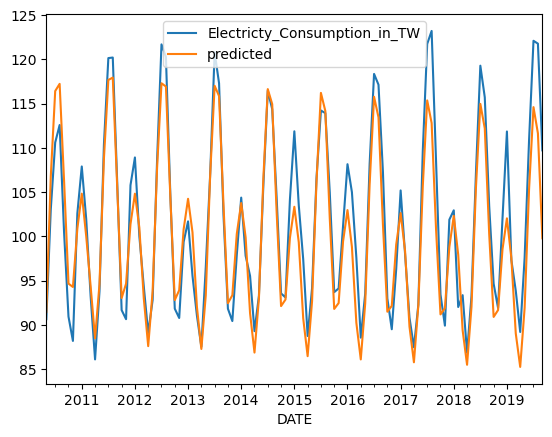

In [73]:
test[['Electricty_Consumption_in_TW','predicted']].plot()

The diagram illustrates that the ARIMA model exhibits good prediction accuracy.

# SARIMAX

In [74]:
#Model building
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [75]:
model_Sarima = SARIMAX(train['Electricty_Consumption_in_TW'],order=[2,1,12],seasonal_order=[0,1,0,12])

In [76]:
model_Sarima = model_Sarima.fit()

In [77]:
pred = model_Sarima.predict(start = pred_start_date, end = pred_end_date)

In [78]:
#Finding the RMSE and Residuals
residuals = test['Electricty_Consumption_in_TW'] - pred

sqrd_errs = residuals **2
mse = np.mean(sqrd_errs)
rmse = np.sqrt(mse)

In [79]:
#Finding RMSPE and MAPE
rmspe = np.sqrt(np.mean(((test['Electricty_Consumption_in_TW'] - pred) / test['Electricty_Consumption_in_TW']) ** 2)) * 100
mape = mean_absolute_percentage_error(test['Electricty_Consumption_in_TW'],pred)

In [80]:
print('Root Mean Squared Error of SARIMA :',rmse)
print('Root Mean Squared Percentage Error of SARIMA :',rmspe)
print(' Mean Absolute Percetage  Error of SARIMA :',mape)

Root Mean Squared Error of SARIMA : 8.137683098409298
Root Mean Squared Percentage Error of SARIMA : 8.251838870625424
 Mean Absolute Percetage  Error of SARIMA : 0.06921782296271785


In [81]:
test['predicted_sarima'] = pred

<AxesSubplot:xlabel='DATE'>

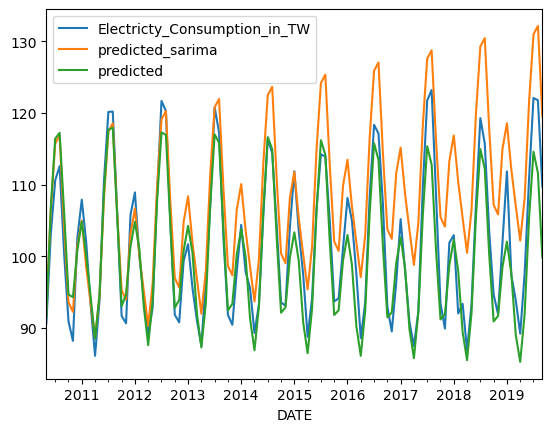

In [82]:
#Ploting the diagram for the actual data,predicted SARIMAX and predicted ARIMA
test[['Electricty_Consumption_in_TW','predicted_sarima','predicted']].plot()

Since ARIMA demonstrates superior accuracy compared to SARIMAX, we will utilize the ARIMA model to forecast demand estimation for the next 1-2 years.

In [83]:
from pandas.tseries.offsets import DateOffset
future_dates = [df.index[-1]+ DateOffset(months=x) for x in range(0,24)]

In [84]:
future_dates

[Timestamp('2019-09-01 00:00:00'),
 Timestamp('2019-10-01 00:00:00'),
 Timestamp('2019-11-01 00:00:00'),
 Timestamp('2019-12-01 00:00:00'),
 Timestamp('2020-01-01 00:00:00'),
 Timestamp('2020-02-01 00:00:00'),
 Timestamp('2020-03-01 00:00:00'),
 Timestamp('2020-04-01 00:00:00'),
 Timestamp('2020-05-01 00:00:00'),
 Timestamp('2020-06-01 00:00:00'),
 Timestamp('2020-07-01 00:00:00'),
 Timestamp('2020-08-01 00:00:00'),
 Timestamp('2020-09-01 00:00:00'),
 Timestamp('2020-10-01 00:00:00'),
 Timestamp('2020-11-01 00:00:00'),
 Timestamp('2020-12-01 00:00:00'),
 Timestamp('2021-01-01 00:00:00'),
 Timestamp('2021-02-01 00:00:00'),
 Timestamp('2021-03-01 00:00:00'),
 Timestamp('2021-04-01 00:00:00'),
 Timestamp('2021-05-01 00:00:00'),
 Timestamp('2021-06-01 00:00:00'),
 Timestamp('2021-07-01 00:00:00'),
 Timestamp('2021-08-01 00:00:00')]

In [85]:
future_new_df = pd.DataFrame(index = future_dates[1:],columns=new_df.columns)

In [86]:
new_df = pd.concat([new_df,future_new_df])

In [87]:
new_df.tail(30)

,Electricty_Consumption_in_TW,Electricty_Consumption_First_diff,Electricty_Consumption_12th_diff
2019-03-01,93.8406,-3.4855,0.4880
2019-04-01,89.1873,-4.6533,2.3487
2019-05-01,97.5860,8.3987,4.3499
2019-06-01,110.8580,13.2720,3.7571
2019-07-01,122.1014,11.2434,2.8140
2019-08-01,121.7765,-0.3249,6.0657
2019-09-01,109.7190,-12.0575,6.3120
2019-10-01,NaN,NaN,NaN
2019-11-01,NaN,NaN,NaN
2019-12-01,NaN,NaN,NaN


In [88]:
start_date = future_dates[1]
end_date = future_dates[-1]

In [89]:
new_df['forecast'] = model_Arima.predict(start=start_date,end=end_date)

<AxesSubplot:>

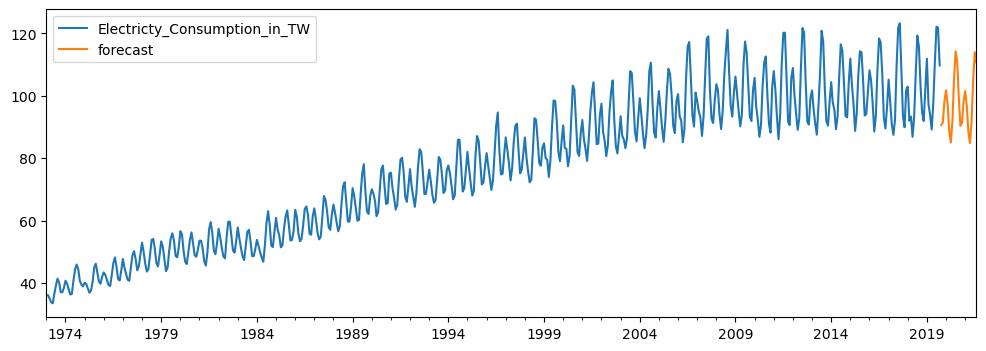

The diagram illustrates a close alignment between the predicted and actual values.

In [91]:
#demand estimation for next 1-2 years
new_df['forecast'].dropna()

2019-10-01     90.631601
2019-11-01     91.489195
2019-12-01     98.323927
2020-01-01    101.773628
2020-02-01     97.214090
2020-03-01     88.680574
2020-04-01     85.030323
2020-05-01     91.829034
2020-06-01    105.213772
2020-07-01    114.262609
2020-08-01    111.118029
2020-09-01     99.333938
2020-10-01     90.399075
2020-11-01     91.347615
2020-12-01     98.153081
2021-01-01    101.539337
2021-02-01     96.907278
2021-03-01     88.379180
2021-04-01     84.854057
2021-05-01     91.775393
2021-06-01    105.122102
2021-07-01    113.947251
2021-08-01    110.630635
Name: forecast, dtype: float64

In [92]:
df

,Electricty_Consumption_in_TW,Electricty_Consumption_First_diff,Electricty_Consumption_12th_diff
DATE,,,
1973-01-01,35.9728,NaN,NaN
1973-02-01,36.1334,0.1606,NaN
1973-03-01,35.0625,-1.0709,NaN
1973-04-01,33.8416,-1.2209,NaN
1973-05-01,33.5107,-0.3309,NaN
...,...,...,...
2019-05-01,97.5860,8.3987,4.3499
2019-06-01,110.8580,13.2720,3.7571
2019-07-01,122.1014,11.2434,2.8140


In [93]:
df=df.drop(['Electricty_Consumption_First_diff','Electricty_Consumption_12th_diff'],axis=1)

# ETS MODEL

In [94]:
#Train test split
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [95]:
train

,Electricty_Consumption_in_TW
DATE,
1973-01-01,35.9728
1973-02-01,36.1334
1973-03-01,35.0625
1973-04-01,33.8416
1973-05-01,33.5107
...,...
2009-12-01,101.8014
2010-01-01,105.7413
2010-02-01,96.4428


In [96]:
#Model building
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
endog = train.values.reshape(-1)
ets_model = ETSModel(endog, error='add', trend='add', seasonal='add', seasonal_periods=12)

In [97]:
ets_model = ets_model.fit()

In [98]:
test_pred = ets_model.forecast(steps=len(test))

In [99]:
#Finding RMSE,RMSPE, and MAPE
rmse = np.sqrt(mean_squared_error(test['Electricty_Consumption_in_TW'], test_pred))
rmspe = np.sqrt(np.mean(((test['Electricty_Consumption_in_TW'] - pred) / test['Electricty_Consumption_in_TW']) ** 2)) * 100
mape = mean_absolute_percentage_error(test['Electricty_Consumption_in_TW'],pred)


In [100]:
print("Root Mean Squared Error on Test Data:", rmse)
print("Root Mean Squared Percentage Error on Test Data:", rmspe)
print("Mean Absolute Percentage Error on Test Data:", mape)

Root Mean Squared Error on Test Data: 8.0210282941255
Root Mean Squared Percentage Error on Test Data: 8.251838870625424
Mean Absolute Percentage Error on Test Data: 0.06921782296271785


The metrics also indicate a high level of accuracy for the ETS model.

In [115]:
#Predicting for demand estimation for next 1-2 years
forecast_horizon = 24
forecast = ets_model.forecast(steps=forecast_horizon)

In [116]:
forecast

array([ 93.14768319, 106.95598224, 115.29814954, 115.78075389,
       103.83699624,  93.52579049,  91.38404499, 100.28771422,
       104.16709494,  97.77647245,  93.71215035,  89.01694733,
        94.86694494, 108.67524399, 117.0174113 , 117.50001564,
       105.55625799,  95.24505225,  93.10330674, 102.00697597,
       105.88635669,  99.4957342 ,  95.4314121 ,  90.73620908])

In [117]:
future_date = [df.index[-1]+ DateOffset(months=x) for x in range(0,25)]

future_df = pd.DataFrame(index = future_date[1:],columns=df.columns)

forecasted_df = pd.concat([df,future_df])


In [118]:
missing_data = forecasted_df[forecasted_df['Electricty_Consumption_in_TW'].isnull()]
missing_data['Electricty_Consumption_in_TW'] = forecast[:len(missing_data)]

In [119]:
forecasted_df.update(missing_data)

In [121]:
forecasted_df

,Electricty_Consumption_in_TW
1973-01-01,35.972800
1973-02-01,36.133400
1973-03-01,35.062500
1973-04-01,33.841600
1973-05-01,33.510700
...,...
2021-05-01,102.006976
2021-06-01,105.886357
2021-07-01,99.495734
2021-08-01,95.431412


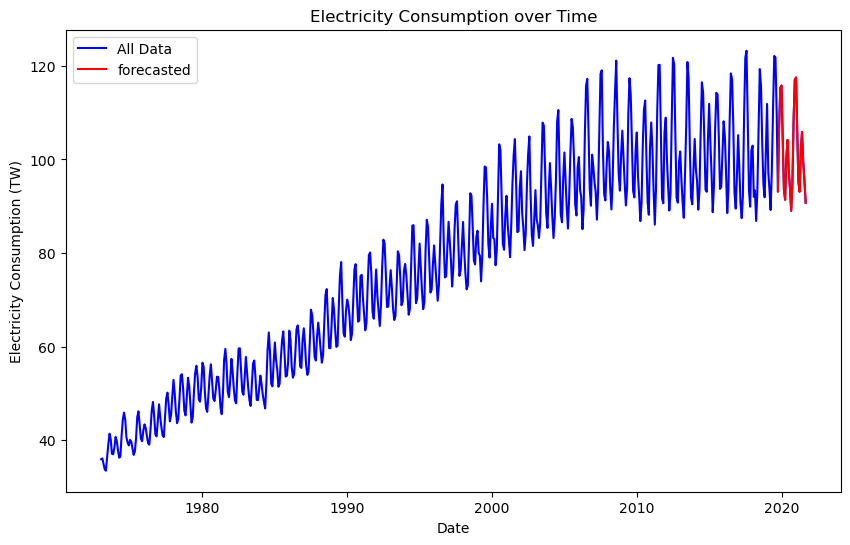

In [122]:
#Ploting the diagram actual data with predicted
plt.figure(figsize=(10, 6))

plt.plot(forecasted_df.index, forecasted_df['Electricty_Consumption_in_TW'], color='blue', label='All Data')
plt.plot(missing_data.index, missing_data['Electricty_Consumption_in_TW'], color='red', label='forecasted')

plt.xlabel('Date')
plt.ylabel('Electricity Consumption (TW)')
plt.title('Electricity Consumption over Time')
plt.legend()

plt.show()

The diagram also illustrates a close alignment between the predicted and actual values.

In [123]:
forecasted_df

,Electricty_Consumption_in_TW
1973-01-01,35.972800
1973-02-01,36.133400
1973-03-01,35.062500
1973-04-01,33.841600
1973-05-01,33.510700
...,...
2021-05-01,102.006976
2021-06-01,105.886357
2021-07-01,99.495734
2021-08-01,95.431412


# Decomposition

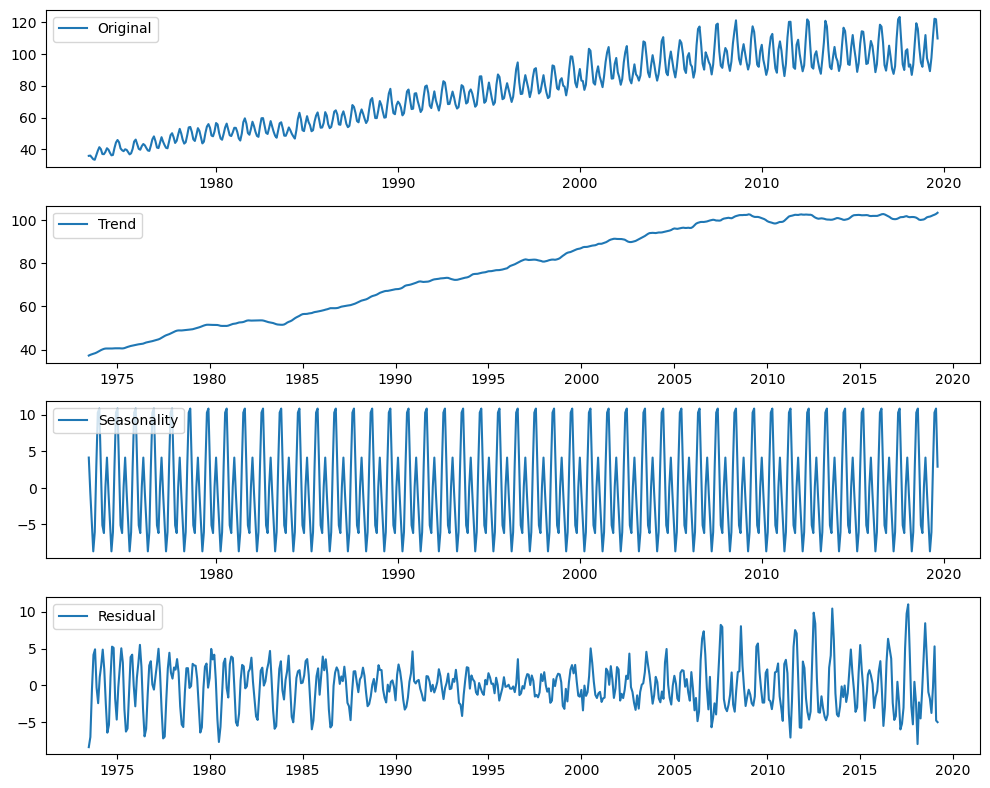

In [124]:

from statsmodels.tsa.seasonal import seasonal_decompose


#Perform seasonal decomposition
decomposition = seasonal_decompose(df, model='additive')  
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

#Visualize the individual components
plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(df, label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [125]:
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
trend_cleaned = trend.dropna()
seasonal_cleaned = seasonal.loc[trend_cleaned.index]

#Prepare input features (time index) for linear regression
X = np.arange(len(trend_cleaned)).reshape(-1, 1)
y = trend_cleaned.values.reshape(-1, 1)

#Fit linear regression model
model = LinearRegression()
model.fit(X, y)

#Forecast trend values for the next 2 years (24 months)
future_time_index = np.arange(len(trend), len(trend) + 24).reshape(-1, 1)
forecasted_trend_values = model.predict(future_time_index)

#Forecast seasonal component 
#Assuming additive seasonal component
seasonal_average = seasonal_cleaned.groupby(seasonal_cleaned.index.month).mean()
forecasted_seasonal_values = np.tile(seasonal_average.values, 2)  # Repeat seasonal averages for 2 years

#Combine trend and seasonal forecasts to obtain overall forecasts
overall_forecasts = forecasted_trend_values.flatten() + forecasted_seasonal_values

#Create a dfFrame for the forecasts
forecast_index = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=24, freq='MS')
forecast_df = pd.DataFrame(overall_forecasts, index=forecast_index, columns=['Forecast'])

# isplay the forecasts
print(forecast_df)

              Forecast
2019-10-01  118.684406
2019-11-01  113.974304
2019-12-01  110.322124
2020-01-01  106.274962
2020-02-01  109.030135
2020-03-01  118.149644
2020-04-01  125.615930
2020-05-01  126.298100
2020-06-01  118.493252
2020-07-01  110.626837
2020-08-01  109.693091
2020-09-01  116.105001
2020-10-01  120.263310
2020-11-01  115.553209
2020-12-01  111.901028
2021-01-01  107.853867
2021-02-01  110.609040
2021-03-01  119.728549
2021-04-01  127.194834
2021-05-01  127.877005
2021-06-01  120.072157
2021-07-01  112.205742
2021-08-01  111.271996
2021-09-01  117.683906


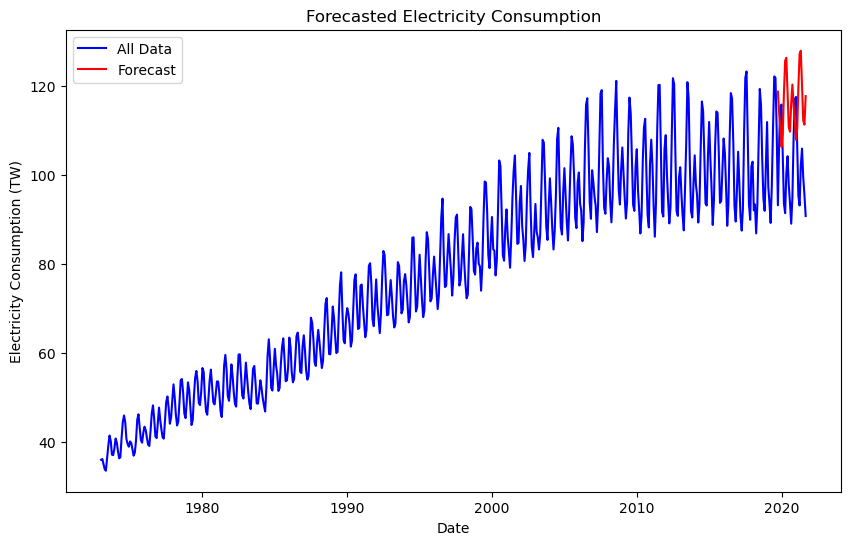

In [126]:
plt.figure(figsize=(10, 6))

plt.plot(forecasted_df.index, forecasted_df['Electricty_Consumption_in_TW'], color='blue', label='All Data')
plt.plot(forecast_df.index, forecast_df['Forecast'], color='red', label='Forecast')


plt.xlabel('Date')
plt.ylabel('Electricity Consumption (TW)')
plt.title('Forecasted Electricity Consumption')
plt.legend()


plt.show()

Upon validation, it is observed that the decomposition method does not yield predictions as accurate as the other two methods

My final conclusion is that, based on the comparison of prediction accuracy using both metrics and diagrams, the ARIMA model outperforms the others.